In [51]:
# Block 1: Installing Setup and Dependencies


!pip install web3 requests pandas numpy scikit-learn matplotlib seaborn

import json
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
from typing import List, Dict, Any
warnings.filterwarnings('ignore')

# Compound V2 Contract Addresses (Ethereum Mainnet)
COMPOUND_CONTRACTS = {
    'cETH': '0x4Ddc2D193948926D02f9B1fE9e1daa0718270ED5',
    'cDAI': '0x5d3a536E4D6DbD6114cc1Ead35777bAB15e5e1c',
    'cUSDC': '0x39AA39c021dfbaE8faC545936693aC917d5E7563',
    'cUSDT': '0xf650C3d88D12dB855b8bf7d11Be6C55A4e07dCC9',
    'cWBTC': '0xC11b1268C1A384e55C48c2391d8d480264A3A7F4',
    'cUNI': '0x35A18000230DA775CAc24873d00Ff85BccdeD550',
    'cLINK': '0xFAce851a4921ce59e912d19329929CE6da6EB0c7',
    'cCOMP': '0x70e36f6BF80a52b3B46b3aF8e106CC0ed743E8e4',
    'cBAT': '0x6C8c6b02E7b2BE14d4fA6022Dfd6d75921D90E4E',
    'cZRX': '0xB3319f5d18Bc0D84dD1b4825Dcde5d5f7266d407'
}

# Etherscan API Configuration
ETHERSCAN_API_KEY = "KXBVZZXDJA843BQEGXJ9J5YXTSDDPMCTSF"
ETHERSCAN_BASE_URL = "https://api.etherscan.io/api"

print("Setup complete. Fetch Etherscan API key from https://etherscan.io/apis")
print(" Replace 'YourEtherscanAPIKey' with your actual API key , ignore if done already ")

Setup complete. Fetch Etherscan API key from https://etherscan.io/apis
 Replace 'YourEtherscanAPIKey' with your actual API key , ignore if done already 


In [52]:
# Block 2: Loading Wallet Addresses from Google Drive CSV

def load_wallet_addresses_from_drive():
    """Load wallet addresses from the Google Drive CSV file."""

    # Google Drive file ID
    file_id = "1DfC_w7zEHGrlVJDogUwjtaftMcIQtPvU"
    direct_download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

    try:
        print("Downloading wallet addresses from Google Drive...")

        # Download and reading the CSV
        response = requests.get(direct_download_url)
        response.raise_for_status()

        with open('wallet_addresses.csv', 'wb') as f:
            f.write(response.content)

        # Read the CSV
        df = pd.read_csv('wallet_addresses.csv')
        print(f" CSV columns: {df.columns.tolist()}")
        print(f"First few rows:")
        print(df.head())

        # Extract wallet addresses (adjust column name as needed)
        possible_columns = ['wallet', 'address', 'wallet_address', 'wallet_id', 'Wallet']

        wallet_column = None
        for col in possible_columns:
            if col in df.columns:
                wallet_column = col
                break

        if wallet_column is None:
            wallet_column = df.columns[0]
            print(f"⚠️ Using first column '{wallet_column}' as wallet addresses")

        wallet_list = df[wallet_column].dropna().unique().tolist()

        # ensuring address they start with 0x and are 42 characters)
        clean_wallets = []
        for wallet in wallet_list:
            wallet = str(wallet).strip()
            if wallet.startswith('0x') and len(wallet) == 42:
                clean_wallets.append(wallet.lower())

        print(f"Loaded {len(clean_wallets)} valid wallet addresses")
        print(f"Sample addresses: {clean_wallets[:3]}")

        return clean_wallets

    except Exception as e:
        print(f"Error loading wallet addresses: {e}")
        return []

# Test the function
wallet_addresses = load_wallet_addresses_from_drive()

 CSV columns: ['wallet_id']
First few rows:
                                    wallet_id
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1  0x06b51c6882b27cb05e712185531c1f74996dd988
2  0x0795732aacc448030ef374374eaae57d2965c16c
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
Loaded 103 valid wallet addresses
Sample addresses: ['0x0039f22efb07a647557c7c5d17854cfd6d489ef3', '0x06b51c6882b27cb05e712185531c1f74996dd988', '0x0795732aacc448030ef374374eaae57d2965c16c']


In [53]:
# Block 3: Etherscan API Functions for Compound V2 Data

def get_compound_transactions(wallet_address: str, max_retries: int = 3) -> List[Dict]:
    """
    Fetching all Compound V2 transactions for a wallet address using Etherscan API.
    """
    all_transactions = []

    # Geting transactions for each Compound contract
    for token_name, contract_address in COMPOUND_CONTRACTS.items():
        print(f"  Fetching {token_name} transactions...")

        for attempt in range(max_retries):
            try:
                params = {
                    'module': 'account',
                    'action': 'tokentx',
                    'contractaddress': contract_address,
                    'address': wallet_address,
                    'page': 1,
                    'offset': 10000,
                    'startblock': 0,
                    'endblock': 99999999,
                    'sort': 'desc',
                    'apikey': ETHERSCAN_API_KEY
                }

                response = requests.get(ETHERSCAN_BASE_URL, params=params)
                response.raise_for_status()
                data = response.json()

                if data['status'] == '1' and data['result']:

                    for tx in data['result']:
                        processed_tx = process_compound_transaction(tx, token_name, wallet_address)
                        if processed_tx:
                            all_transactions.append(processed_tx)

                # Limiting the rate as Etherscan allows 5 calls per second for free version :-)
                time.sleep(0.2)
                break

            except Exception as e:
                print(f"     Attempt {attempt + 1} failed for {token_name}: {e}")
                if attempt == max_retries - 1:
                    print(f"     Max retries reached for {token_name}")
                time.sleep(1)

    normal_txs = get_normal_transactions(wallet_address)
    all_transactions.extend(normal_txs)

    return all_transactions

def get_normal_transactions(wallet_address: str) -> List[Dict]:
    """Get normal transactions that might be Compound interactions."""
    try:
        params = {
            'module': 'account',
            'action': 'txlist',
            'address': wallet_address,
            'startblock': 0,
            'endblock': 99999999,
            'page': 1,
            'offset': 1000,
            'sort': 'desc',
            'apikey': ETHERSCAN_API_KEY
        }

        response = requests.get(ETHERSCAN_BASE_URL, params=params)
        data = response.json()

        compound_txs = []
        if data['status'] == '1' and data['result']:
            for tx in data['result']:

                to_address = tx.get('to', '').lower()
                if to_address in [addr.lower() for addr in COMPOUND_CONTRACTS.values()]:
                    processed_tx = process_normal_compound_transaction(tx, wallet_address)
                    if processed_tx:
                        compound_txs.append(processed_tx)

        time.sleep(0.2)
        return compound_txs

    except Exception as e:
        print(f"   Error fetching normal transactions: {e}")
        return []

def process_compound_transaction(tx: Dict, token_name: str, wallet_address: str) -> Dict:
    """Process a token transaction from Etherscan into our format."""
    try:
        # Determining action based on from/to addresses
        from_addr = tx.get('from', '').lower()
        to_addr = tx.get('to', '').lower()
        wallet_addr = wallet_address.lower()

        if from_addr == wallet_addr and to_addr == COMPOUND_CONTRACTS[token_name].lower():
            action = 'mint'  # User sending tokens to cToken contract (supply/deposit)
        elif from_addr == COMPOUND_CONTRACTS[token_name].lower() and to_addr == wallet_addr:
            action = 'redeem'  # User receiving tokens from cToken contract (withdraw)
        else:
            return None

        # Converting amount (tokens have different decimals)
        amount = float(tx.get('value', 0)) / (10 ** int(tx.get('tokenDecimal', 18)))

        return {
            'userWallet': wallet_address.lower(),
            'action': action,
            'actionData': {'amount': amount},
            'timestamp': int(tx.get('timeStamp', 0)),
            'txHash': tx.get('hash', ''),
            'token': token_name,
            'blockNumber': int(tx.get('blockNumber', 0))
        }

    except Exception as e:
        print(f"     Error processing transaction: {e}")
        return None

def process_normal_compound_transaction(tx: Dict, wallet_address: str) -> Dict:
    """Process normal transactions that are Compound interactions."""
    try:
        # Basic processing for direct contract calls


        value = float(tx.get('value', 0)) / (10 ** 18)
        to_addr = tx.get('to', '').lower()

        token_name = None
        for name, addr in COMPOUND_CONTRACTS.items():
            if addr.lower() == to_addr:
                token_name = name
                break

        if not token_name:
            return None



        return {
            'userWallet': wallet_address.lower(),
            'action': 'interact',  # Generic interaction
            'actionData': {'amount': value},
            'timestamp': int(tx.get('timeStamp', 0)),
            'txHash': tx.get('hash', ''),
            'token': token_name,
            'blockNumber': int(tx.get('blockNumber', 0))
        }

    except Exception as e:
        return None

print("Etherscan API functions ready")
print(" Make sure to set your ETHERSCAN_API_KEY variable!")


print("\n Testing functions in Block 3...")

if 'wallet_addresses' in globals() and wallet_addresses:
    sample_wallet_address = wallet_addresses[0]
    print(f"Testing get_compound_transactions with first wallet from list: {sample_wallet_address}")
    try:
        sample_transactions = get_compound_transactions(sample_wallet_address)
        print(f"Found {len(sample_transactions)} transactions for the sample wallet.")
    except Exception as e:
        print(f"Error testing get_compound_transactions: {e}")
else:
    print(" Wallet addresses not loaded or list is empty. Cannot run test with first wallet.")
    print("Please ensure the wallet addresses cell (Block 2) was run successfully.")

    sample_wallet_address = "0x00000000219ab540356cbb839cbe05303d7705fa" # Example placeholder
    print(f"Testing get_compound_transactions with placeholder wallet: {sample_wallet_address}")
    try:
        sample_transactions = get_compound_transactions(sample_wallet_address)
        print(f"Found {len(sample_transactions)} transactions for the sample wallet.")
    except Exception as e:
        print(f"Error testing get_compound_transactions: {e}")

print(" Block 3 function testing complete.")

Etherscan API functions ready
 Make sure to set your ETHERSCAN_API_KEY variable!

 Testing functions in Block 3...
Testing get_compound_transactions with first wallet from list: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
  Fetching cETH transactions...
  Fetching cDAI transactions...
  Fetching cUSDC transactions...
  Fetching cUSDT transactions...
  Fetching cWBTC transactions...
  Fetching cUNI transactions...
  Fetching cLINK transactions...
  Fetching cCOMP transactions...
  Fetching cBAT transactions...
  Fetching cZRX transactions...
Found 22 transactions for the sample wallet.
 Block 3 function testing complete.


In [56]:
# Block 4: Main Data Fetching Function

def fetch_all_wallet_data(wallet_addresses: List[str], max_wallets: int = None) -> pd.DataFrame:
    """
    Fetch Compound V2 transaction data for all wallets.
    UPDATED: Better handling to ensure all wallets are processed
    """
    if max_wallets:
        wallet_addresses = wallet_addresses[:max_wallets]

    print(f" Starting data collection for {len(wallet_addresses)} wallets...")


    all_transactions = []
    processed_wallets = set()
    failed_wallets = []

    for i, wallet in enumerate(wallet_addresses, 1):
        print(f"\n Processing wallet {i}/{len(wallet_addresses)}: {wallet}")

        try:

            wallet_transactions = get_compound_transactions(wallet)

            if wallet_transactions:
                all_transactions.extend(wallet_transactions)
                processed_wallets.add(wallet.lower())
                print(f"  Found {len(wallet_transactions)} transactions")
            else:
                # Even if no transactions found, creating a minimal entry
                minimal_tx = {
                    'userWallet': wallet.lower(),
                    'action': 'no_activity',
                    'actionData': {'amount': 0},
                    'timestamp': int(time.time()),
                    'txHash': '0x0',
                    'token': 'NONE',
                    'blockNumber': 0
                }
                all_transactions.append(minimal_tx)
                processed_wallets.add(wallet.lower())
                print(f"  ℹ️ No transactions found - added minimal entry")

            # Progress update every 10 wallets so you don't get bored :-)
            if i % 10 == 0:
                print(f"\n Progress: {i}/{len(wallet_addresses)} wallets processed")
                print(f" Total transactions collected: {len(all_transactions)}")

        except Exception as e:
            print(f"   Error processing wallet {wallet}: {e}")
            failed_wallets.append(wallet)


            minimal_tx = {
                'userWallet': wallet.lower(),
                'action': 'error',
                'actionData': {'amount': 0},
                'timestamp': int(time.time()),
                'txHash': '0x0',
                'token': 'ERROR',
                'blockNumber': 0
            }
            all_transactions.append(minimal_tx)
            processed_wallets.add(wallet.lower())
            continue

    print(f"\n Data collection complete!")
    print(f" Total transactions: {len(all_transactions)}")
    print(f" Wallets processed: {len(processed_wallets)}")
    print(f" Wallets failed: {len(failed_wallets)}")

    if failed_wallets:
        print(f" Failed wallets: {failed_wallets[:5]}...")

    # Converting to DataFrame
    if all_transactions:
        df = pd.DataFrame(all_transactions)
        print(f" DataFrame shape: {df.shape}")
        print(f" Unique wallets in data: {df['userWallet'].nunique()}")
        print(f" Action types found: {df['action'].value_counts().to_dict()}")
        return df
    else:
        print(" No transactions found. Creating minimal DataFrame.")

        minimal_data = []
        for wallet in wallet_addresses:
            minimal_data.append({
                'userWallet': wallet.lower(),
                'action': 'no_activity',
                'actionData': {'amount': 0},
                'timestamp': int(time.time()),
                'txHash': '0x0',
                'token': 'NONE',
                'blockNumber': 0
            })
        return pd.DataFrame(minimal_data)

def enhance_compound_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Enhance the basic transaction data with Compound-specific features.
    """
    if df.empty:
        return df

    print("🔧 Enhancing Compound transaction data...")


    action_mapping = {
        'mint': 'deposit',
        'redeem': 'redeemunderlying',
        'interact': 'interact',
        'borrow': 'borrow',
        'repay': 'repay',
        'liquidationcall': 'liquidationcall'
    }

    df['action'] = df['action'].map(action_mapping).fillna(df['action'])

    # Adding risk indicators specific to Compound

    df['is_high_value'] = df['actionData'].apply(
        lambda x: x.get('amount', 0) > 1000 if isinstance(x, dict) else False
    )

    # Add time-based features
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
    df['hour_of_day'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek

    print(f" Enhanced data with additional features")
    return df

# --- Test Section for Block 4 Functions ---
print("\n🧪 Testing functions in Block 4...")


if 'wallet_addresses' in globals() and wallet_addresses:

    sample_wallets_for_test = wallet_addresses[:3] # Test with 3 wallets
    print(f"Testing fetch_all_wallet_data with {len(sample_wallets_for_test)} wallets from list...")
    try:
        sample_fetched_df = fetch_all_wallet_data(sample_wallets_for_test)
        print(f"Fetched {len(sample_fetched_df)} total transactions for sample wallets.")
        print("\nTesting enhance_compound_data with the fetched data...")
        sample_df_enhanced = enhance_compound_data(sample_fetched_df.copy())
        print(" enhance_compound_data test successful.")
        print("\n Sample Enhanced DataFrame head:")
        display(sample_df_enhanced.head())
    except Exception as e:
        print(f"Error testing Block 4 functions: {e}")
        import traceback
        traceback.print_exc()
else:
    print("⚠️ Wallet addresses not loaded or list is empty. Cannot run test with sample wallets.")
    print("Please ensure the wallet addresses cell (Block 2) was run successfully.")
    # Fallback to a placeholder if wallet_addresses is not available
    sample_wallet_address_fallback = "0x00000000219ab540356cbb839cbe05303d7705fa" # Example placeholder
    print(f"Testing fetch_all_wallet_data with placeholder wallet: {sample_wallet_address_fallback}")
    try:
        sample_fetched_df = fetch_all_wallet_data([sample_wallet_address_fallback])
        print(f"Fetched {len(sample_fetched_df)} total transactions for placeholder wallet.")
        print("\nTesting enhance_compound_data with the fetched data...")
        sample_df_enhanced = enhance_compound_data(sample_fetched_df.copy()) # Use a copy
        print(" enhance_compound_data test successful.")
        print("\n Sample Enhanced DataFrame head:")
        display(sample_df_enhanced.head()) # Display head of enhanced data
    except Exception as e:
        print(f"Error testing Block 4 functions: {e}")
        import traceback
        traceback.print_exc()


print("Block 4 function testing complete.")


🧪 Testing functions in Block 4...
Testing fetch_all_wallet_data with 3 wallets from list...
 Starting data collection for 3 wallets...

 Processing wallet 1/3: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
  Fetching cETH transactions...
  Fetching cDAI transactions...
  Fetching cUSDC transactions...
  Fetching cUSDT transactions...
  Fetching cWBTC transactions...
  Fetching cUNI transactions...
  Fetching cLINK transactions...
  Fetching cCOMP transactions...
  Fetching cBAT transactions...
  Fetching cZRX transactions...
  Found 22 transactions

 Processing wallet 2/3: 0x06b51c6882b27cb05e712185531c1f74996dd988
  Fetching cETH transactions...
  Fetching cDAI transactions...
  Fetching cUSDC transactions...
  Fetching cUSDT transactions...
  Fetching cWBTC transactions...
  Fetching cUNI transactions...
  Fetching cLINK transactions...
  Fetching cCOMP transactions...
  Fetching cBAT transactions...
  Fetching cZRX transactions...
  Found 1 transactions

 Processing wallet 3/3: 0x0795

,userWallet,action,actionData,timestamp,txHash,token,blockNumber,is_high_value,hour_of_day,day_of_week
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,deposit,{'amount': 4996.96135103},2020-07-15 20:54:10,0x900d391db2eff42e6b3fa7311934b227de1259f13d7f...,cETH,10466349,True,20,2
1,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,redeemunderlying,{'amount': 4996.96135103},2020-06-23 00:33:57,0x32caa484d8e47a0aacbd7b91511487e163b8accdbd6e...,cETH,10318839,True,0,1
2,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,deposit,{'amount': 4997.8080362},2019-09-14 05:51:03,0x54f30f06c66bb76a821fa5bb1f65307650bcc28b6b7f...,cETH,8545907,True,5,5
3,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,redeemunderlying,{'amount': 4997.8080362},2019-09-02 19:28:39,0x3703dbfc7075fda1f753b6813dd80b27298af7063590...,cETH,8472628,True,19,0
4,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,deposit,{'amount': 1428592.40657892},2020-07-15 20:56:10,0x918f67febf2f528dc8e4b430d7188fea2e85e1b4d42b...,cUSDT,10466356,True,20,2


Block 4 function testing complete.


In [57]:
def engineer_compound_features(df: pd.DataFrame) -> pd.DataFrame:

    print("🔧 Starting Compound-specific feature engineering...")

    if df.empty:
        print(" Empty DataFrame provided")
        return pd.DataFrame()

    # Get all unique wallets to ensure none are missed
    all_wallets = df['userWallet'].unique()
    print(f"Processing features for {len(all_wallets)} unique wallets")


    if 'actionData' not in df.columns:
        df['actionData'] = [{'amount': 0} for _ in range(len(df))]

    df['amount'] = df['actionData'].apply(safe_numeric_conversion)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')


    active_df = df[~df['action'].isin(['no_activity', 'error'])].copy()

    features = {}



    wallet_activity = active_df.groupby('userWallet').size() if not active_df.empty else pd.Series(dtype=int)
    features['transaction_count'] = pd.Series(0, index=all_wallets).add(wallet_activity, fill_value=0)

    wallet_actions = active_df.groupby('userWallet')['action'].nunique() if not active_df.empty else pd.Series(dtype=int)
    features['unique_actions'] = pd.Series(0, index=all_wallets).add(wallet_actions, fill_value=0)

    if 'token' in df.columns:
        wallet_tokens = active_df.groupby('userWallet')['token'].nunique() if not active_df.empty else pd.Series(dtype=int)
        features['unique_tokens'] = pd.Series(0, index=all_wallets).add(wallet_tokens, fill_value=0)
    else:
        features['unique_tokens'] = pd.Series(0, index=all_wallets)

    # === TIME-BASED FEATURES ===
    if not active_df.empty and 'timestamp' in active_df.columns and not active_df['timestamp'].isna().all():
        time_range = active_df.groupby('userWallet')['timestamp'].apply(
            lambda x: (x.max() - x.min()).days + 1 if len(x) > 1 else 1
        )
        features['days_active'] = pd.Series(1, index=all_wallets).add(time_range, fill_value=1)
        features['avg_daily_transactions'] = features['transaction_count'] / features['days_active']


        max_date = active_df['timestamp'].max()
        recent_cutoff = max_date - pd.Timedelta(days=30)
        recent_df = active_df[active_df['timestamp'] >= recent_cutoff]
        recent_activity = recent_df.groupby('userWallet').size() if not recent_df.empty else pd.Series(dtype=int)
        features['recent_activity'] = pd.Series(0, index=all_wallets).add(recent_activity, fill_value=0)
    else:
        features['days_active'] = pd.Series(1, index=all_wallets)
        features['avg_daily_transactions'] = features['transaction_count']
        features['recent_activity'] = pd.Series(0, index=all_wallets)

    # === FINANCIAL FEATURES ===

    for feature_name in ['total_deposits', 'total_withdrawals', 'total_borrows', 'total_repays', 'total_interactions',
                        'avg_deposit_size', 'avg_withdrawal_size', 'avg_borrow_size', 'avg_repay_size']:
        features[feature_name] = pd.Series(0.0, index=all_wallets)

    if not active_df.empty:
        # Calculate financial features only for active wallets
        deposit_data = active_df[active_df['action'].isin(['deposit', 'mint'])].groupby('userWallet')['amount']
        withdraw_data = active_df[active_df['action'].isin(['redeemunderlying', 'redeem'])].groupby('userWallet')['amount']
        borrow_data = active_df[active_df['action'] == 'borrow'].groupby('userWallet')['amount']
        repay_data = active_df[active_df['action'] == 'repay'].groupby('userWallet')['amount']
        interact_data = active_df[active_df['action'] == 'interact'].groupby('userWallet')['amount']

        # Update features with actual data where available
        if not deposit_data.sum().empty:
            features['total_deposits'] = features['total_deposits'].add(deposit_data.sum(), fill_value=0)
            features['avg_deposit_size'] = features['avg_deposit_size'].add(deposit_data.mean(), fill_value=0)

        if not withdraw_data.sum().empty:
            features['total_withdrawals'] = features['total_withdrawals'].add(withdraw_data.sum(), fill_value=0)
            features['avg_withdrawal_size'] = features['avg_withdrawal_size'].add(withdraw_data.mean(), fill_value=0)

        if not borrow_data.sum().empty:
            features['total_borrows'] = features['total_borrows'].add(borrow_data.sum(), fill_value=0)
            features['avg_borrow_size'] = features['avg_borrow_size'].add(borrow_data.mean(), fill_value=0)

        if not repay_data.sum().empty:
            features['total_repays'] = features['total_repays'].add(repay_data.sum(), fill_value=0)
            features['avg_repay_size'] = features['avg_repay_size'].add(repay_data.mean(), fill_value=0)

        if not interact_data.sum().empty:
            features['total_interactions'] = features['total_interactions'].add(interact_data.sum(), fill_value=0)

    # === ACTION COUNTS ===
    action_list = ['deposit', 'mint', 'redeemunderlying', 'redeem', 'borrow', 'repay', 'interact', 'liquidationcall']

    if not active_df.empty:
        action_counts = active_df.groupby(['userWallet', 'action']).size().unstack(fill_value=0)
        for action in action_list:
            if action in action_counts.columns:
                features[f'{action}_count'] = pd.Series(0, index=all_wallets).add(action_counts[action], fill_value=0)
            else:
                features[f'{action}_count'] = pd.Series(0, index=all_wallets)
    else:
        for action in action_list:
            features[f'{action}_count'] = pd.Series(0, index=all_wallets)

    # === COMPOUND-SPECIFIC RISK FEATURES ===
    features['liquidation_count'] = features.get('liquidationcall_count', pd.Series(0, index=all_wallets))
    features['supply_count'] = features.get('deposit_count', pd.Series(0, index=all_wallets)) + features.get('mint_count', pd.Series(0, index=all_wallets))
    features['withdraw_count'] = features.get('redeemunderlying_count', pd.Series(0, index=all_wallets)) + features.get('redeem_count', pd.Series(0, index=all_wallets))

    # Financial ratios (with proper handling of division by zero)
    features['total_volume'] = (features['total_deposits'] + features['total_withdrawals'] +
                               features['total_borrows'] + features['total_repays'])

    features['repay_ratio'] = features['total_repays'] / (features['total_borrows'] + 1e-8)
    features['borrow_deposit_ratio'] = features['total_borrows'] / (features['total_deposits'] + 1e-8)
    features['withdraw_deposit_ratio'] = features['total_withdrawals'] / (features['total_deposits'] + 1e-8)

    # Portfolio diversity
    features['activity_diversity'] = features['unique_actions'] / 6  # Max 6 action types
    features['token_diversity'] = features['unique_tokens'] / max(len(COMPOUND_CONTRACTS), 1)

    # === BEHAVIORAL PATTERNS ===

    if not active_df.empty:
        amount_cv = active_df.groupby('userWallet')['amount'].apply(
            lambda x: x.std() / (x.mean() + 1e-8) if len(x) > 1 else 0
        )
        features['amount_volatility'] = pd.Series(0.0, index=all_wallets).add(amount_cv, fill_value=0)
    else:
        features['amount_volatility'] = pd.Series(0.0, index=all_wallets)

    # High-value transaction frequency
    if 'is_high_value' in active_df.columns and not active_df.empty:
        high_value_ratio = active_df[active_df['is_high_value']].groupby('userWallet').size() / features['transaction_count']
        features['high_value_tx_ratio'] = pd.Series(0.0, index=all_wallets).add(high_value_ratio, fill_value=0)
    else:
        features['high_value_tx_ratio'] = pd.Series(0.0, index=all_wallets)

    # === RISK INDICATORS ===
    # Bot-like behavior indicators
    features['potential_bot_score'] = (
        (features['transaction_count'] > 100) * 0.3 +  # High frequency
        (features['avg_daily_transactions'] > 10) * 0.3 +  # Very active
        (features['amount_volatility'] < 0.1) * 0.2 +  # Consistent amounts
        (features['unique_actions'] <= 2) * 0.2  # Limited action types
    )

    # Risk score components
    features['leverage_risk'] = np.clip(features['borrow_deposit_ratio'], 0, 5)
    features['liquidity_risk'] = features['liquidation_count'] * 2
    features['activity_risk'] = np.where(features['transaction_count'] < 5, 2, 0)

    # === FINAL PROCESSING ===
    features_df = pd.DataFrame(features).fillna(0)
    features_df['userWallet'] = features_df.index
    features_df = features_df.reset_index(drop=True)

    # Ensure all wallets are present
    missing_wallets = set(all_wallets) - set(features_df['userWallet'])
    if missing_wallets:
        print(f"⚠️ Adding {len(missing_wallets)} missing wallets with zero features")
        for wallet in missing_wallets:
            zero_row = {col: 0 for col in features_df.columns if col != 'userWallet'}
            zero_row['userWallet'] = wallet
            features_df = pd.concat([features_df, pd.DataFrame([zero_row])], ignore_index=True)

    # Ensure all numeric columns
    numeric_columns = features_df.select_dtypes(include=[np.number]).columns
    features_df[numeric_columns] = features_df[numeric_columns].fillna(0)

    print(f" Created feature set for {len(features_df)} wallets with {len(features_df.columns)-1} features")
    print(f" All wallets accounted for: {len(features_df['userWallet'].unique()) == len(all_wallets)}")
    print(f" Key features: {list(features_df.columns[:10])}")

    return features_df# Block 5: Updated Feature Engineering for Compound V2

def safe_numeric_conversion(actionData):
    """Safely extract numeric amount value."""
    try:
        return float(actionData.get('amount', 0)) if isinstance(actionData, dict) else 0.0
    except (ValueError, TypeError):
        return 0.0

def engineer_compound_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate comprehensive features for Compound V2 transaction data.
    Enhanced for DeFi risk assessment.
    """
    print("Starting Compound-specific feature engineering...")

    if df.empty:
        print(" Empty DataFrame provided")
        return pd.DataFrame()

    # Ensure required columns exist
    if 'actionData' not in df.columns:
        df['actionData'] = [{'amount': 0} for _ in range(len(df))]

    df['amount'] = df['actionData'].apply(safe_numeric_conversion)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

    features = {}

    # === BASIC ACTIVITY FEATURES ===
    features['transaction_count'] = df.groupby('userWallet').size()
    features['unique_actions'] = df.groupby('userWallet')['action'].nunique()
    features['unique_tokens'] = df.groupby('userWallet')['token'].nunique() if 'token' in df.columns else 0

    # === TIME-BASED FEATURES ===
    if 'timestamp' in df.columns and not df['timestamp'].isna().all():
        features['days_active'] = df.groupby('userWallet')['timestamp'].apply(
            lambda x: (x.max() - x.min()).days + 1 if len(x) > 1 else 1
        )
        features['avg_daily_transactions'] = features['transaction_count'] / features['days_active']

        # Recent activity (last 30 days from max date)
        max_date = df['timestamp'].max()
        recent_cutoff = max_date - pd.Timedelta(days=30)
        recent_df = df[df['timestamp'] >= recent_cutoff]
        features['recent_activity'] = recent_df.groupby('userWallet').size()
    else:
        features['days_active'] = 1
        features['avg_daily_transactions'] = features['transaction_count']
        features['recent_activity'] = 0

    # === FINANCIAL FEATURES ===
    # Group by action types (using Compound terminology)
    deposit_data = df[df['action'].isin(['deposit', 'mint'])].groupby('userWallet')['amount']
    withdraw_data = df[df['action'].isin(['redeemunderlying', 'redeem'])].groupby('userWallet')['amount']
    borrow_data = df[df['action'] == 'borrow'].groupby('userWallet')['amount']
    repay_data = df[df['action'] == 'repay'].groupby('userWallet')['amount']
    interact_data = df[df['action'] == 'interact'].groupby('userWallet')['amount']

    # Totals
    features['total_deposits'] = deposit_data.sum()
    features['total_withdrawals'] = withdraw_data.sum()
    features['total_borrows'] = borrow_data.sum()
    features['total_repays'] = repay_data.sum()
    features['total_interactions'] = interact_data.sum()

    # Averages
    features['avg_deposit_size'] = deposit_data.mean()
    features['avg_withdrawal_size'] = withdraw_data.mean()
    features['avg_borrow_size'] = borrow_data.mean()
    features['avg_repay_size'] = repay_data.mean()

    # === ACTION COUNTS ===
    action_counts = df.groupby(['userWallet', 'action']).size().unstack(fill_value=0)
    for action in ['deposit', 'mint', 'redeemunderlying', 'redeem', 'borrow', 'repay', 'interact', 'liquidationcall']:
        features[f'{action}_count'] = action_counts.get(action, 0)

    # === COMPOUND-SPECIFIC RISK FEATURES ===
    # Liquidation risk
    features['liquidation_count'] = features.get('liquidationcall_count', 0)

    # Lending behavior
    features['supply_count'] = features.get('deposit_count', 0) + features.get('mint_count', 0)
    features['withdraw_count'] = features.get('redeemunderlying_count', 0) + features.get('redeem_count', 0)

    # Financial ratios
    features['total_volume'] = (features['total_deposits'] + features['total_withdrawals'] +
                               features['total_borrows'] + features['total_repays'])

    features['repay_ratio'] = features['total_repays'] / (features['total_borrows'] + 1e-8)
    features['borrow_deposit_ratio'] = features['total_borrows'] / (features['total_deposits'] + 1e-8)
    features['withdraw_deposit_ratio'] = features['total_withdrawals'] / (features['total_deposits'] + 1e-8)

    # Portfolio diversity
    features['activity_diversity'] = features['unique_actions'] / 6  # Max 6 action types
    features['token_diversity'] = features['unique_tokens'] / len(COMPOUND_CONTRACTS)

    # === BEHAVIORAL PATTERNS ===
    # Transaction size consistency (coefficient of variation)
    amount_cv = df.groupby('userWallet')['amount'].apply(
        lambda x: x.std() / (x.mean() + 1e-8) if len(x) > 1 else 0
    )
    features['amount_volatility'] = amount_cv

    # High-value transaction frequency
    if 'is_high_value' in df.columns:
        features['high_value_tx_ratio'] = df[df['is_high_value']].groupby('userWallet').size() / features['transaction_count']
    else:
        features['high_value_tx_ratio'] = 0

    # === RISK INDICATORS ===
    # Bot-like behavior indicators
    features['potential_bot_score'] = (
        (features['transaction_count'] > 100) * 0.3 +  # High frequency
        (features['avg_daily_transactions'] > 10) * 0.3 +  # Very active
        (features['amount_volatility'] < 0.1) * 0.2 +  # Consistent amounts
        (features['unique_actions'] <= 2) * 0.2  # Limited action types
    )

    # Risk score components
    features['leverage_risk'] = np.clip(features['borrow_deposit_ratio'], 0, 5)
    features['liquidity_risk'] = features['liquidation_count'] * 2
    features['activity_risk'] = np.where(features['transaction_count'] < 5, 2, 0)

    # === FINAL PROCESSING ===
    features_df = pd.DataFrame(features).fillna(0)
    features_df['userWallet'] = features_df.index
    features_df = features_df.reset_index(drop=True)

    # Ensure all numeric columns
    numeric_columns = features_df.select_dtypes(include=[np.number]).columns
    features_df[numeric_columns] = features_df[numeric_columns].fillna(0)

    print(f" Created feature set for {len(features_df)} wallets with {len(features_df.columns)-1} features")
    print(f" Key features: {list(features_df.columns[:10])}")

    return features_df

print(" Compound-specific feature engineering ready")

 Compound-specific feature engineering ready


In [58]:
# Block 6: Updated Risk Scoring System for Compound V2

def calculate_compound_risk_score(features_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate risk scores (0-1000) based on Compound V2 transaction behavior.
    UPDATED: Better distribution across full 0-1000 range
    """
    print(" Calculating Compound-specific risk scores...")

    if features_df.empty:
        print(" Empty features DataFrame")
        return features_df

    scores = []
    score_components = []

    for _, row in features_df.iterrows():
        # Start with lower base score for better distribution
        base_score = 300
        components = {'base': base_score}

        # === POSITIVE RISK INDICATORS (INCREASE SCORE) ===


        activity_score = 0
        # Transaction volume bonus
        if row['transaction_count'] > 0:
            activity_score += min(row['transaction_count'] * 5, 150)

        # Daily activity bonus
        if row['days_active'] > 0:
            daily_bonus = min(row['avg_daily_transactions'] * 10, 80)
            activity_score += daily_bonus

        # Diversity bonus
        activity_score += row['activity_diversity'] * 70

        components['activity'] = activity_score
        base_score += activity_score

        # 2. Financial Responsibility (0-250 points)
        financial_score = 0

        # Volume-based scoring
        if row['total_volume'] > 0:
            volume_score = min(np.log1p(row['total_volume']) * 20, 100)
            financial_score += volume_score

        # Good repayment behavior
        if row['total_borrows'] > 0:
            repay_bonus = min(row['repay_ratio'] * 120, 120)
            financial_score += repay_bonus
        elif row['total_deposits'] > 100:  # Bonus for suppliers who don't borrow
            financial_score += 80

        # Leverage management
        if row['borrow_deposit_ratio'] <= 0.5:  # Very conservative
            financial_score += 80  # Increased
        elif row['borrow_deposit_ratio'] <= 1.0:  # Conservative
            financial_score += 50  # Increased
        elif row['borrow_deposit_ratio'] <= 1.5:  # Moderate
            financial_score += 30

        components['financial'] = financial_score
        base_score += financial_score

        # 3. Portfolio Diversification (0-150 points) -
        diversity_score = 0
        # Token diversification
        diversity_score += row['token_diversity'] * 75
        # Action diversification
        diversity_score += row['activity_diversity'] * 75

        components['diversity'] = diversity_score
        base_score += diversity_score

        # 4. Stability and Maturity (0-200 points) -
        stability_score = 0

        # Long-term presence
        if row['days_active'] > 365:  # 1+ years
            stability_score += 80
        elif row['days_active'] > 180:  # 6+ months
            stability_score += 60
        elif row['days_active'] > 30:  # 1+ month
            stability_score += 40
        elif row['days_active'] > 7:  # 1+ week
            stability_score += 20

        # Transaction consistency
        if row['amount_volatility'] < 0.3:  # Very consistent
            stability_score += 50
        elif row['amount_volatility'] < 0.7:  # Moderately consistent
            stability_score += 30

        # Recent activity
        if row['recent_activity'] > 5:
            stability_score += 40
        elif row['recent_activity'] > 0:
            stability_score += 20

        # Balanced activity pattern
        if row['supply_count'] > 0 and row['withdraw_count'] > 0:
            stability_score += 30

        components['stability'] = stability_score
        base_score += stability_score

        # === NEGATIVE RISK INDICATORS (DECREASE SCORE) ===

        # 1. Liquidation History (MORE SEVERE PENALTIES)
        liquidation_penalty = row['liquidation_count'] * 150
        base_score -= min(liquidation_penalty, 300)
        components['liquidation_penalty'] = -min(liquidation_penalty, 300)

        # 2. Excessive Leverage (MORE SEVERE)
        leverage_penalty = 0
        if row['borrow_deposit_ratio'] > 3:
            leverage_penalty = min((row['borrow_deposit_ratio'] - 3) * 100, 250)
        elif row['borrow_deposit_ratio'] > 2:
            leverage_penalty = min((row['borrow_deposit_ratio'] - 2) * 60, 180)
        base_score -= leverage_penalty
        components['leverage_penalty'] = -leverage_penalty

        # 3. Bot-like Behavior (MORE SEVERE)
        bot_penalty = row['potential_bot_score'] * 150
        base_score -= bot_penalty
        components['bot_penalty'] = -bot_penalty

        # 4. Insufficient Activity
        activity_penalty = 0
        if row['transaction_count'] == 0:  # No activity at all
            activity_penalty = 200  # Major penalty
        elif row['transaction_count'] < 2:  # Very low activity
            activity_penalty = 100  # Reduced from previous
        elif row['transaction_count'] < 5:  # Low activity
            activity_penalty = 50   # Reduced penalty
        base_score -= activity_penalty
        components['activity_penalty'] = -activity_penalty

        # 5. Poor Repayment History
        repayment_penalty = 0
        if row['total_borrows'] > 0:
            if row['repay_ratio'] < 0.3:  # Very poor repayment
                repayment_penalty = 200
            elif row['repay_ratio'] < 0.7:  # Poor repayment
                repayment_penalty = 100
            elif row['repay_ratio'] < 0.9:  # Below average repayment
                repayment_penalty = 50
        base_score -= repayment_penalty
        components['repayment_penalty'] = -repayment_penalty

        # 6. Suspicious Patterns
        suspicious_penalty = 0

        # Only borrowing, no supplying (risky pattern)
        if row['total_borrows'] > 0 and row['total_deposits'] == 0:
            suspicious_penalty += 80

        # Extremely high frequency (potential bot)
        if row['avg_daily_transactions'] > 20:
            suspicious_penalty += 60

        # No recent activity despite historical presence
        if row['days_active'] > 90 and row['recent_activity'] == 0:
            suspicious_penalty += 40

        # High volatility in transaction amounts (suspicious)
        if row['amount_volatility'] > 2.0:
            suspicious_penalty += 50

        base_score -= suspicious_penalty
        components['suspicious_penalty'] = -suspicious_penalty

        # === NORMALIZATION AND FINAL ADJUSTMENTS ===

        # Ensure score is within 0-1000 range
        final_score = max(0, min(1000, base_score))

        # Apply additional spread enhancement
        if final_score > 750:  # Boost high performers
            final_score = min(1000, final_score + 50)
        elif final_score < 250:  # Further penalize poor performers
            final_score = max(0, final_score - 50)

        scores.append(final_score)
        score_components.append(components)

    # Add scores to dataframe
    features_df['risk_score'] = scores

    # Create detailed scoring breakdown
    components_df = pd.DataFrame(score_components)
    components_df['userWallet'] = features_df['userWallet']

    print(f"Risk score calculation complete")
    print(f" Score range: {min(scores):.1f} - {max(scores):.1f}")
    print(f" Mean score: {np.mean(scores):.1f}")
    print(f" Median score: {np.median(scores):.1f}")

    return features_df, components_df

def analyze_compound_risk_scores(features_df: pd.DataFrame, components_df: pd.DataFrame = None):
    """Analyze the distribution and characteristics of risk scores."""
    print("\n" + "="*50)
    print("🎯 COMPOUND V2 RISK SCORE ANALYSIS")
    print("="*50)

    scores = features_df['risk_score']

    # Basic statistics
    print(f"\n📊 BASIC STATISTICS")
    print(f"Wallets analyzed: {len(scores)}")
    print(f"Score range: {scores.min():.1f} - {scores.max():.1f}")
    print(f"Mean: {scores.mean():.2f}")
    print(f"Median: {scores.median():.2f}")
    print(f"Standard deviation: {scores.std():.2f}")

    # Risk categories
    print(f"\n📊 RISK CATEGORIES")
    risk_categories = [
        (0, 200, "Very High Risk", "🔴"),
        (200, 400, "High Risk", "🟠"),
        (400, 600, "Medium Risk", "🟡"),
        (600, 800, "Low Risk", "🟢"),
        (800, 1000, "Very Low Risk", "🔵")
    ]

    for low, high, label, emoji in risk_categories:
        count = ((scores >= low) & (scores < high)).sum()
        percentage = (count / len(scores)) * 100
        print(f"{emoji} {label} ({low}-{high}): {count} wallets ({percentage:.1f}%)")

    # Detailed analysis by risk level
    print(f"\n RISK LEVEL CHARACTERISTICS")

    # High Risk Wallets (bottom 20%)
    high_risk_threshold = scores.quantile(0.2)
    high_risk_wallets = features_df[features_df['risk_score'] <= high_risk_threshold]

    print(f"\n🔴 HIGH RISK WALLETS (≤ {high_risk_threshold:.1f})")
    print(f"Count: {len(high_risk_wallets)}")
    if len(high_risk_wallets) > 0:
        print(f"Avg transactions: {high_risk_wallets['transaction_count'].mean():.1f}")
        print(f"Avg liquidations: {high_risk_wallets['liquidation_count'].mean():.1f}")
        print(f"Avg borrow/deposit ratio: {high_risk_wallets['borrow_deposit_ratio'].mean():.2f}")
        print(f"Avg repay ratio: {high_risk_wallets['repay_ratio'].mean():.2f}")
        print(f"Bot-like score: {high_risk_wallets['potential_bot_score'].mean():.2f}")

    # Low Risk Wallets (top 20%)
    low_risk_threshold = scores.quantile(0.8)
    low_risk_wallets = features_df[features_df['risk_score'] >= low_risk_threshold]

    print(f"\n🟢 LOW RISK WALLETS (≥ {low_risk_threshold:.1f})")
    print(f"Count: {len(low_risk_wallets)}")
    if len(low_risk_wallets) > 0:
        print(f"Avg transactions: {low_risk_wallets['transaction_count'].mean():.1f}")
        print(f"Avg liquidations: {low_risk_wallets['liquidation_count'].mean():.1f}")
        print(f"Avg borrow/deposit ratio: {low_risk_wallets['borrow_deposit_ratio'].mean():.2f}")
        print(f"Avg repay ratio: {low_risk_wallets['repay_ratio'].mean():.2f}")
        print(f"Token diversity: {low_risk_wallets['token_diversity'].mean():.2f}")

    # Score component analysis
    if components_df is not None:
        print(f"\n SCORE COMPONENT CONTRIBUTIONS")
        numeric_components = components_df.select_dtypes(include=[np.number])
        avg_components = numeric_components.mean()
        print("Average contribution by component:")
        for component, value in avg_components.items():
            if component != 'base':
                print(f"  {component}: {value:.1f}")

    return {
        'high_risk_wallets': high_risk_wallets,
        'low_risk_wallets': low_risk_wallets,
        'risk_categories': risk_categories
    }

print(" Compound risk scoring system ready")

 Compound risk scoring system ready


In [62]:
# Block 7: Main Pipeline Integration and Testing

def run_compound_risk_pipeline(test_mode: bool = True, max_wallets: int = 5):
    """
    Main pipeline to fetch Compound data and generate risk scores.
    UPDATED: Better wallet handling and score distribution
    """
    print(" STARTING COMPOUND V2 RISK SCORING PIPELINE")
    print("=" * 50)

    try:
        # Step 1: Load wallet addresses
        print("\n STEP 1: Loading wallet addresses...")
        wallet_addresses = load_wallet_addresses_from_drive()

        if not wallet_addresses:
            print(" No wallet addresses loaded. Check your Google Drive file.")
            return None

        original_count = len(wallet_addresses)
        print(f" Loaded {original_count} wallet addresses from file")

        # Step 2: Fetch transaction data
        print(f"\n STEP 2: Fetching transaction data...")
        if test_mode:
            print(f" TEST MODE: Processing only {max_wallets} wallets")
            df = fetch_all_wallet_data(wallet_addresses, max_wallets=max_wallets)
        else:
            print(f" FULL MODE: Processing all {len(wallet_addresses)} wallets")
            df = fetch_all_wallet_data(wallet_addresses)

        if df.empty:
            print(" Creating minimal DataFrame for all wallets...")
            # Create minimal data for all wallets
            target_wallets = wallet_addresses[:max_wallets] if test_mode else wallet_addresses
            for wallet in target_wallets:
                minimal_data.append({
                    'userWallet': wallet.lower(),
                    'action': 'no_activity',
                    'actionData': {'amount': 0},
                    'timestamp': int(time.time()),
                    'txHash': '0x0',
                    'token': 'NONE',
                    'blockNumber': 0
                })
            df = pd.DataFrame(minimal_data)


        unique_wallets_in_data = df['userWallet'].nunique()
        expected_wallets = max_wallets if test_mode else original_count
        print(f"📊 Wallets in data: {unique_wallets_in_data} (expected: {expected_wallets})")


        # Step 3: Enhance data
        print(f"\n STEP 3: Enhancing transaction data...")
        df_enhanced = enhance_compound_data(df)


        # Step 4: Feature engineering
        print(f"\n STEP 4: Engineering features...")
        features_df = engineer_compound_features(df_enhanced)

        if features_df.empty:
            print(" Feature engineering failed")
            return None

        # Verify all wallets are present
        final_wallet_count = len(features_df)
        print(f" Final wallet count in features: {final_wallet_count}")

        if final_wallet_count != expected_wallets:
            print(f" Wallet count mismatch! Expected: {expected_wallets}, Got: {final_wallet_count}")
            # Add any missing wallets
            target_wallets = wallet_addresses[:max_wallets] if test_mode else wallet_addresses
            missing_wallets = set([w.lower() for w in target_wallets]) - set(features_df['userWallet'])
            if missing_wallets:
                print(f"🔧 Adding {len(missing_wallets)} missing wallets...")
                for wallet in missing_wallets:
                    zero_row = {col: 0 for col in features_df.columns if col != 'userWallet'}
                    zero_row['userWallet'] = wallet
                    features_df = pd.concat([features_df, pd.DataFrame([zero_row])], ignore_index=True)


        # Step 5: Calculate risk scores
        print(f"\n STEP 5: Calculating risk scores...")
        features_df, components_df = calculate_compound_risk_score(features_df)


        # Step 6: Analyze results
        print(f"\n STEP 6: Analyzing results...")
        analysis_results = analyze_compound_risk_scores(features_df, components_df)


        print("\n PIPELINE COMPLETED SUCCESSFULLY!")
        print(f" Final output: {len(features_df)} wallets with risk scores")


        return {
            'features_df': features_df,
            'components_df': components_df,
            'analysis_results': analysis_results,
            'raw_data': df_enhanced
        }

    except Exception as e:
        print(f" Pipeline failed with error: {e}")
        import traceback
        traceback.print_exc()
        return None

def export_results(results: dict, filename_prefix: str = "compound_risk_scores"):
    """Export results to CSV files in the required format."""
    if not results:
        print(" No results to export")
        return

    features_df = results['features_df']

    # Create the required output format: wallet_id, score
    output_df = pd.DataFrame({
        'wallet_id': features_df['userWallet'],
        'score': features_df['risk_score'].round(0).astype(int)
    })

    # Sort by score (descending - highest scores first)
    output_df = output_df.sort_values('score', ascending=False)

    # Remove any duplicates (just in case)
    output_df = output_df.drop_duplicates(subset=['wallet_id'])

    # Export main results
    output_filename = f"{filename_prefix}.csv"
    output_df.to_csv(output_filename, index=False)
    print(f" Exported main results to: {output_filename}")

    # Export detailed features for analysis
    detailed_filename = f"{filename_prefix}_detailed.csv"
    features_df.to_csv(detailed_filename, index=False)
    print(f" Exported detailed analysis to: {detailed_filename}")

    # Export score components
    if 'components_df' in results and results['components_df'] is not None:
        components_filename = f"{filename_prefix}_components.csv"
        results['components_df'].to_csv(components_filename, index=False)
        print(f" Exported score components to: {components_filename}")


    # Display summary statistics
    print(f"\n EXPORT SUMMARY:")
    print(f"Total wallets: {len(output_df)}")
    print(f"Score range: {output_df['score'].min()} - {output_df['score'].max()}")
    print(f"Mean score: {output_df['score'].mean():.1f}")
    print(f"Median score: {output_df['score'].median():.1f}")

    # Display sample output
    print(f"\n SAMPLE OUTPUT (first 10 rows):")
    print(output_df.head(10).to_string(index=False))


    return output_df


def test_single_wallet(wallet_address: str):
    """Test the pipeline with a single wallet address."""
    print(f" Testing with single wallet: {wallet_address}")

    try:
        # Fetch data for single wallet
        transactions = get_compound_transactions(wallet_address)

        if not transactions:
            print(f"ℹ️ No transactions found for {wallet_address}")
            return None

        # Convert to DataFrame
        df = pd.DataFrame(transactions)
        print(f" Found {len(df)} transactions")
        print(f" Actions: {df['action'].value_counts().to_dict()}")

        # Process through pipeline
        df_enhanced = enhance_compound_data(df)
        features_df = engineer_compound_features(df_enhanced)
        features_df, components_df = calculate_compound_risk_score(features_df)

        print(f"\n🎯 RESULTS FOR {wallet_address}:")
        print(f"Risk Score: {features_df['risk_score'].iloc[0]:.1f}")
        print(f"Transaction Count: {features_df['transaction_count'].iloc[0]}")
        print(f"Total Volume: ${features_df['total_volume'].iloc[0]:.2f}")

        return features_df

    except Exception as e:
        print(f" Test failed: {e}")
        return None



In [63]:
# Run the test pipeline with 3 wallets
test_pipeline_results = run_test_pipeline(3)

🧪 RUNNING TEST PIPELINE WITH 3 WALLETS
📋 Testing wallets: ['0x0039f22efb07a647557c7c5d17854cfd6d489ef3', '0x06b51c6882b27cb05e712185531c1f74996dd988', '0x0795732aacc448030ef374374eaae57d2965c16c']

📥 Processing wallet 1/3: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
  ✅ Found 100 transactions

📥 Processing wallet 2/3: 0x06b51c6882b27cb05e712185531c1f74996dd988
  ✅ Found 4 transactions

📥 Processing wallet 3/3: 0x0795732aacc448030ef374374eaae57d2965c16c
  ✅ Found 3 transactions

🔧 Processing 107 transactions...
⚙️ Engineering features...
Starting Compound-specific feature engineering...
 Created feature set for 3 wallets with 38 features
 Key features: ['transaction_count', 'unique_actions', 'unique_tokens', 'days_active', 'avg_daily_transactions', 'recent_activity', 'total_deposits', 'total_withdrawals', 'total_borrows', 'total_repays']
🎯 Calculating risk scores...
 Calculating Compound-specific risk scores...
Risk score calculation complete
 Score range: 376.7 - 583.3
 Mean score: 450.

In [64]:
# Run the full pipeline
full_pipeline_results = run_compound_risk_pipeline(test_mode=False)

 STARTING COMPOUND V2 RISK SCORING PIPELINE

 STEP 1: Loading wallet addresses...
 CSV columns: ['wallet_id']
First few rows:
                                    wallet_id
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1  0x06b51c6882b27cb05e712185531c1f74996dd988
2  0x0795732aacc448030ef374374eaae57d2965c16c
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
Loaded 103 valid wallet addresses
Sample addresses: ['0x0039f22efb07a647557c7c5d17854cfd6d489ef3', '0x06b51c6882b27cb05e712185531c1f74996dd988', '0x0795732aacc448030ef374374eaae57d2965c16c']
 Loaded 103 wallet addresses from file

 STEP 2: Fetching transaction data...
 FULL MODE: Processing all 103 wallets
 Starting data collection for 103 wallets...

 Processing wallet 1/103: 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
  Fetching cETH transactions...
  Fetching cDAI transactions...
  Fetching cUSDC transactions...
  Fetching cUSDT transactions...
  Fetching cWBTC transactions...
  Fetching c

In [65]:
from google.colab import files

# Get the main output DataFrame from the pipeline results
if 'full_pipeline_results' in globals() and full_pipeline_results and 'features_df' in full_pipeline_results:
    features_df = full_pipeline_results['features_df']
    output_df = pd.DataFrame({
        'wallet_id': features_df['userWallet'],
        'score': features_df['risk_score'].round(0).astype(int)
    })

    # Define the filename
    filename = 'final_scores.csv'

    # Save the DataFrame to a temporary CSV file
    output_df.to_csv(filename, index=False)

    # Download the file
    print(f"Downloading '{filename}'...")
    files.download(filename)
else:
    print("❌ Full pipeline results not found. Please run the full pipeline first.")
    print("You can run it using: full_pipeline_results = run_compound_risk_pipeline(test_mode=False)")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

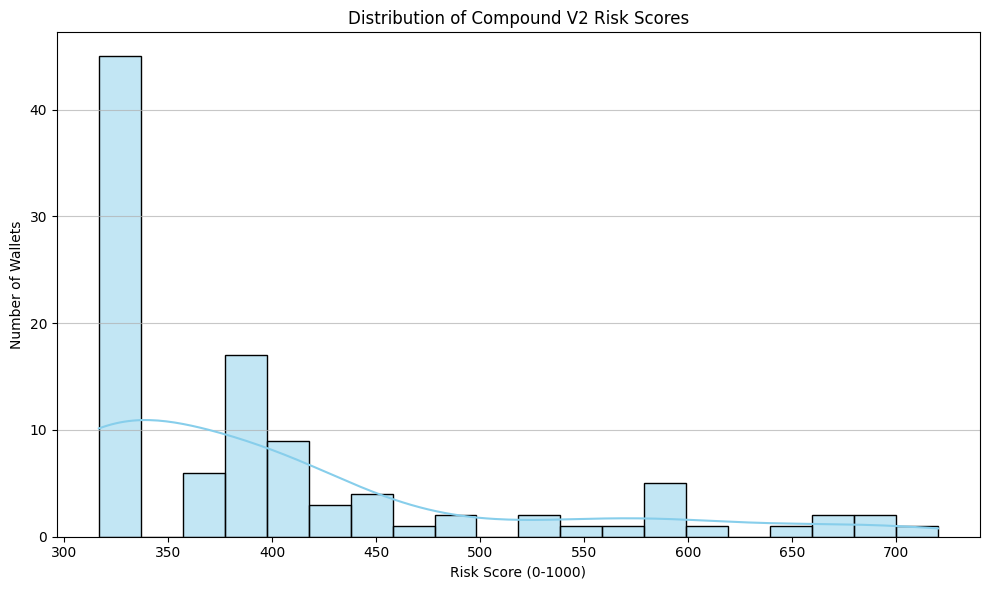

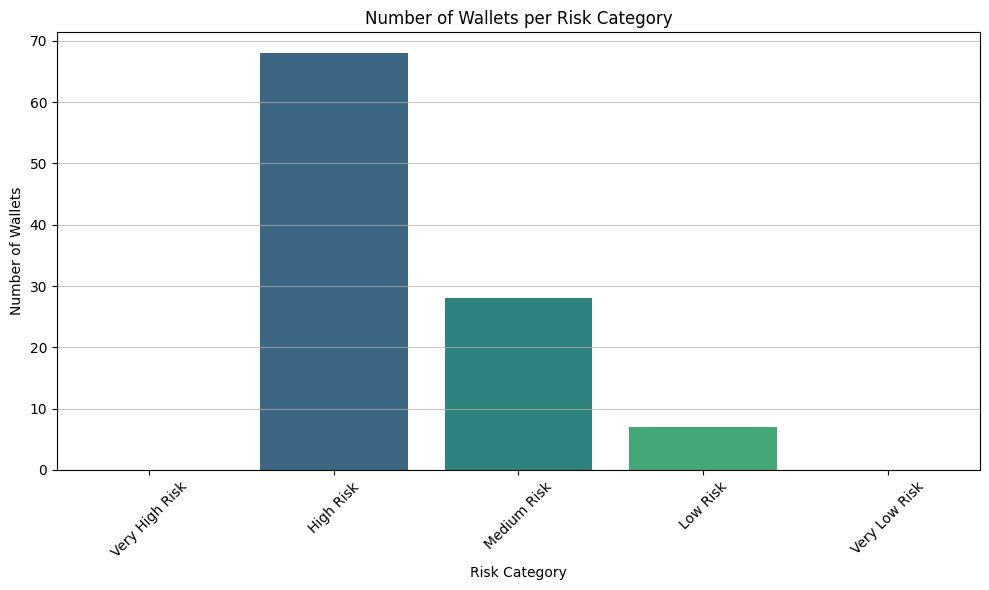

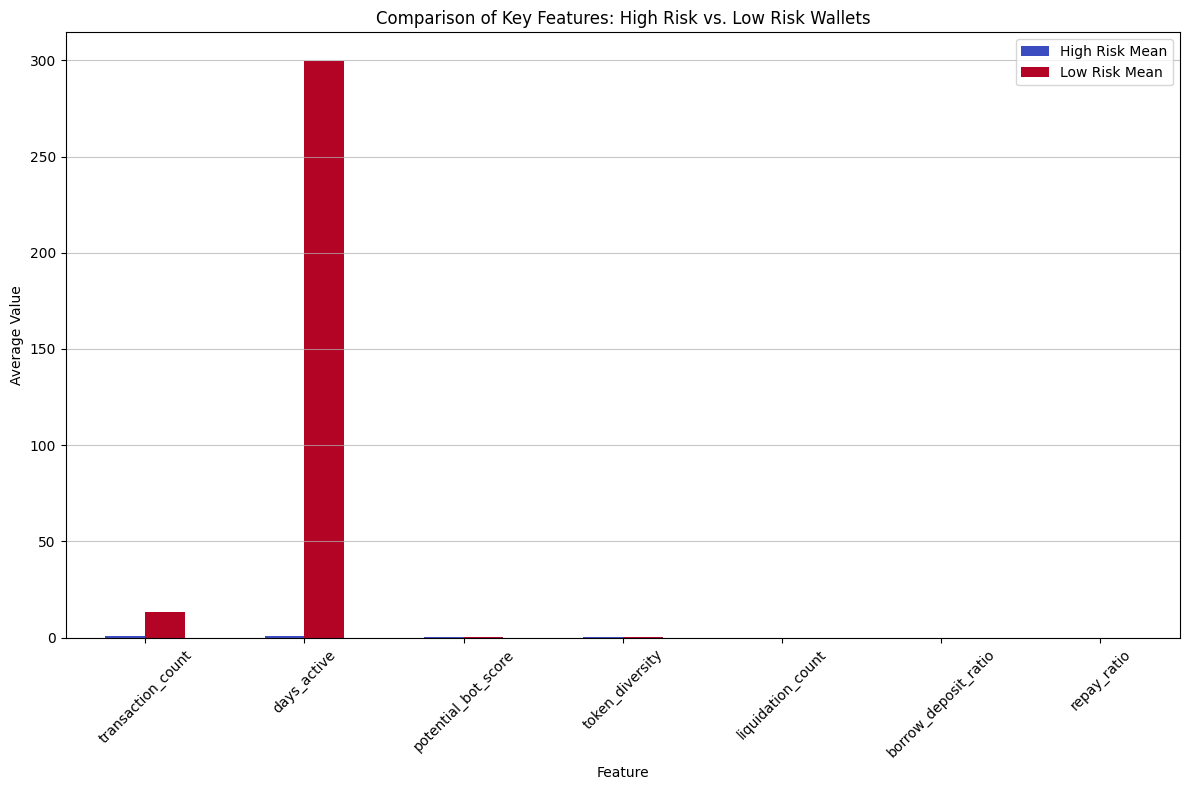


Attempting to download risk_score_distribution.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded risk_score_distribution.png
Attempting to download risk_category_counts.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded risk_category_counts.png
Attempting to download risk_group_feature_comparison.png...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded risk_group_feature_comparison.png


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import files # Import files for downloading
import os # Import os to check file existence

# Assuming 'full_pipeline_results' contains the output from the pipeline
if 'full_pipeline_results' in globals() and full_pipeline_results and 'features_df' in full_pipeline_results:
    features_df = full_pipeline_results['features_df']
    scores = features_df['risk_score']

    # --- Visualization 1: Histogram of Risk Scores ---
    fig1, ax1 = plt.subplots(figsize=(10, 6)) # Use subplots to get figure object
    sns.histplot(scores, bins=20, kde=True, color='skyblue', ax=ax1) # Pass ax to seaborn
    ax1.set_title('Distribution of Compound V2 Risk Scores')
    ax1.set_xlabel('Risk Score (0-1000)')
    ax1.set_ylabel('Number of Wallets')
    ax1.grid(axis='y', alpha=0.7)
    plt.tight_layout()
    hist_filename = 'risk_score_distribution.png'
    fig1.savefig(hist_filename) # Save the figure
    plt.show()


    # --- Visualization 2: Bar Plot of Risk Categories ---
    fig2, ax2 = plt.subplots(figsize=(10, 6)) # Use subplots to get figure object
    risk_categories = [
        (0, 200, "Very High Risk"),
        (200, 400, "High Risk"),
        (400, 600, "Medium Risk"),
        (600, 800, "Low Risk"),
        (800, 1000, "Very Low Risk")
    ]

    category_counts = []
    category_labels = []
    for low, high, label in risk_categories:
        count = ((scores >= low) & (scores < high)).sum()
        category_counts.append(count)
        category_labels.append(label)

    sns.barplot(x=category_labels, y=category_counts, palette='viridis', ax=ax2) # Pass ax to seaborn
    ax2.set_title('Number of Wallets per Risk Category')
    ax2.set_xlabel('Risk Category')
    ax2.set_ylabel('Number of Wallets')
    ax2.tick_params(axis='x', rotation=45) # Removed ha='right'
    ax2.grid(axis='y', alpha=0.7)
    plt.tight_layout()
    categories_filename = 'risk_category_counts.png'
    fig2.savefig(categories_filename) # Save the figure
    plt.show()


    # --- Visualization 3: Comparison of Key Features for High vs. Low Risk Groups ---
    comparison_filename = None # Initialize filename in case plot is not generated
    if 'analysis_results' in full_pipeline_results:
        analysis_results = full_pipeline_results['analysis_results']
        high_risk_wallets_df = analysis_results['high_risk_wallets']
        low_risk_wallets_df = analysis_results['low_risk_wallets']

        if not high_risk_wallets_df.empty and not low_risk_wallets_df.empty:
            comparison_features = [
                'transaction_count',
                'liquidation_count',
                'borrow_deposit_ratio',
                'repay_ratio',
                'potential_bot_score',
                'token_diversity',
                'days_active'
            ]

            high_risk_means = high_risk_wallets_df[comparison_features].mean()
            low_risk_means = low_risk_wallets_df[comparison_features].mean()

            comparison_df = pd.DataFrame({
                'High Risk Mean': high_risk_means,
                'Low Risk Mean': low_risk_means
            })

            comparison_df = comparison_df.sort_values('High Risk Mean', ascending=False) # Sort for better visualization

            fig3, ax3 = plt.subplots(figsize=(12, 8)) # Use subplots to get figure object
            comparison_df.plot(kind='bar', colormap='coolwarm', ax=ax3) # Pass ax to plot method
            ax3.set_title('Comparison of Key Features: High Risk vs. Low Risk Wallets')
            ax3.set_xlabel('Feature')
            ax3.set_ylabel('Average Value')
            ax3.tick_params(axis='x', rotation=45) # Removed ha='right'
            ax3.grid(axis='y', alpha=0.7)
            plt.tight_layout()
            comparison_filename = 'risk_group_feature_comparison.png'
            fig3.savefig(comparison_filename) # Save the figure
            plt.show()
        else:
            print("⚠️ Not enough data in high or low risk groups to generate comparison plot.")


    # --- Download the saved files ---
    print("\nDownloading generated plots...")
    download_files = []

    # Check if files exist and have content before adding to download list
    if os.path.exists(hist_filename) and os.path.getsize(hist_filename) > 0:
        download_files.append(hist_filename)
    if os.path.exists(categories_filename) and os.path.getsize(categories_filename) > 0:
        download_files.append(categories_filename)
    if comparison_filename and os.path.exists(comparison_filename) and os.path.getsize(comparison_filename) > 0:
        download_files.append(comparison_filename)


    if download_files:
        for file in download_files:
            print(f"Attempting to download {file}...")
            try:
                files.download(file)
                print(f"Downloaded {file}")
            except Exception as e:
                print(f"Error downloading {file}: {e}")
    else:
         print("⚠️ No plot files found to download.")

else:
    print("❌ Full pipeline results not found. Please run the full pipeline first.")
    print("You can run it using: full_pipeline_results = run_compound_risk_pipeline(test_mode=False)")